In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/hpge/

/content/gdrive/MyDrive/hpge


In [ ]:
nodes = {}
nodes['dummy_node'] = 0
edge_list = []
node_type_list = []
# edge_list - [s_id,s_type,t_id,t_type,e_type,year]
# sid, s_type, tid, t_type, e_type, timestamp

file = open("acm_output.txt", encoding="utf8")

In [ ]:
def fetchData():
    line = file.readline()
    cnt = 0
    
    while cnt < 10000:
        if not line: break
        if cnt > 0: line = file.readline()
        cnt += 1

        authors = []
        year = ''
        conf = ''

        for i in range(7):
            if i == 1: authors = line[2:-1].split(',')
            if i == 2: year = line[5:-1]
            if i == 3: conf = line[5:-1]
            line = file.readline()
        
        while not line or not(line == '\n'): line = file.readline()

        if nodes.get(conf) == None:
            nodes[conf] = len(nodes.keys())
            node_type_list.append(1)
        conf_id = nodes.get(conf)

        author_ids = []
        for author in authors:
            if nodes.get(author) == None:
                nodes[author] = len(nodes.keys())
                node_type_list.append(0)
            author_id = nodes[author]
            author_ids.append(author_id)
            edge_list.append([str(author_id),'0',str(conf_id),'1','0',year])
            edge_list.append([str(conf_id),'1',str(author_id),'0','0',year])
        
        for i in author_ids:
            for j in author_ids:
                edge_list.append([str(i),'0',str(j),'0','1',year])

In [ ]:
def writeData(filename,edge_list):
    # sid, s_type, tid, t_type, e_type, timestamp
    with open(filename,"w") as data_file:
        
        for edge in edge_list:
            data_file.write(','.join(edge))
            data_file.write("\n")

In [ ]:
fetchData()
print("Number of edges",len(edge_list))
print("Number of nodes", len(nodes.keys())-1)

Number of edges 126737
Number of nodes 17423


In [ ]:
print("Number of edges",len(edge_list))
print("Number of nodes", len(nodes.keys())-1)

Number of edges 126737
Number of nodes 17423


In [ ]:
writeData('data_file.txt',edge_list=edge_list)

In [ ]:
from data_loader import DataLoader

In [ ]:
dl_obj = DataLoader("data_file.txt", 5, 5, 2, ',', 'important')
#                 (file_path, nbr_size, neg_size, num_edge_types,delim,sample_type):

1949 60 17423 126737


In [ ]:
dl_obj.generate_training_dataset("dataset.txt", num_process=10)
# rint(sid, s_type, tid, t_type, e_type, timestamp)

 95%|█████████▍| 120000/126737 [00:10<00:00, 11074.46it/s]


'1;17423;0;8406,3365,4183,1989,7743;17418;17421,17422,17423;1.0;0.4,0.2,0.4;1;1;17423;0;2883,9521,230,4617,790;17418;17421,17422,17423;1.0;0.4,0.2,0.4;1;1\n'

In [ ]:
from input import input_func

data = input_func('dataset.txt',2,126737,5,5,";",",")
# (filename, num_edge_types, batch_size, neg_size=1, nbr_size=1,col_delim1=";", col_delim2=",")

/content/gdrive/MyDrive/hpge/input.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_nums = np.array([ np.array([]) if type(s) == float else np.array(s.split(',')).astype(int) for s in str_np_arr.ravel()])
/content/gdrive/MyDrive/hpge/input.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_nums = np.array([ np.array([]) if type(s) == float else np.array(s.split(',')).astype(int) for s in str_np_arr.ravel()])
/content/gdrive/MyDrive/hpge/input.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
import tensorflow as tf
import pickle as pkl

# print(data[2].dtype)
# data[0] = tf.cast(data[0], dtype = tf.int32)
# print(data[1].dtype)

In [ ]:
from new_model import HHP
global_step = tf.compat.v1.train.get_or_create_global_step()
model = HHP(global_step,0.001,126737,5,5,dl_obj.node_size,128,2,2,0.001)
# global_step, learning_rate, batch_size, neg_size, nbr_size, node_size, node_dim, num_node_types,
                #  num_edge_types,
                #  norm_rate
print(len(model.trainable_variables))
print(model.edge_type_dense[0])

2


In [ ]:
ret = model.__call__(data)
print(len(ret))
print(model.loss(ret[0],ret[1],ret[2]))

3
tf.Tensor(2.3863335, shape=(), dtype=float32)


In [ ]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        output = model.__call__(data)
        loss = model.loss(output[0],output[1],output[2])
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss

In [ ]:
# training the model
y = []
x = []
def train(data,epochs):
    for e in range(epochs):
        loss = train_step(data)
        if e%100 == 0:
          print("Loss",loss)
          x.append(e)
          y.append(loss)

In [ ]:
train(data,1000)

Loss tf.Tensor(2.3863335, shape=(), dtype=float32)
Loss tf.Tensor(0.8910843, shape=(), dtype=float32)
Loss tf.Tensor(0.8288893, shape=(), dtype=float32)
Loss tf.Tensor(0.822021, shape=(), dtype=float32)
Loss tf.Tensor(0.8190619, shape=(), dtype=float32)
Loss tf.Tensor(0.8174866, shape=(), dtype=float32)
Loss tf.Tensor(0.81649536, shape=(), dtype=float32)
Loss tf.Tensor(0.81577945, shape=(), dtype=float32)
Loss tf.Tensor(0.8152451, shape=(), dtype=float32)
Loss tf.Tensor(0.81484693, shape=(), dtype=float32)


Text(0, 0.5, 'Loss')

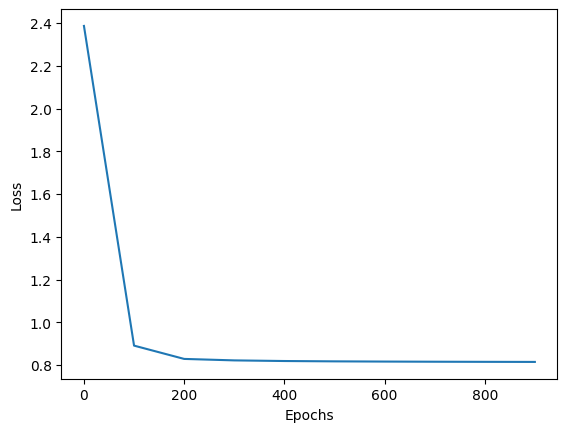

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
pkl.dump([model.embedding, model.edge_type_embed], open("embedding_file", "wb"))
tf.saved_model.save(model,'/')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, normalized_mutual_info_score, adjusted_rand_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pickle as pkl

In [ ]:
node_embed, _ = pkl.load(open("embedding_file", "rb"))

In [ ]:
node_embed = node_embed.numpy()
x_train, x_valid, y_train, y_valid = train_test_split(node_embed, node_type_list, test_size=0.3,random_state=9)

In [ ]:
zero = []
one = []

for i in range(len(node_type_list)):
  if node_type_list[i] == 1: one.append(i)
  else: zero.append(i)

confs = np.repeat(node_embed[one], 35, axis = 0) 
athrs = node_embed[zero]

cy = [1 for _ in range(confs.shape[0])]
ay = [0 for _ in range(athrs.shape[0])]

print(confs.shape, type(node_embed[0]))
print(athrs.shape)

cx_train, cx_valid, cy_train, cy_valid = train_test_split(confs, cy, test_size=0.1,random_state=9)
ax_train, ax_valid, ay_train, ay_valid = train_test_split(athrs, ay, test_size=0.4,random_state=9)

print(cx_train.shape, ax_train.shape)

x_train = np.append(cx_train,ax_train,axis = 0)
x_valid = np.append(cx_valid,ax_valid,axis = 0)
y_train = np.append(cy_train,ay_train,axis = 0)
y_valid = np.append(cy_valid,ay_valid,axis = 0)

(5565, 128) <class 'numpy.ndarray'>
(17264, 128)
(5008, 128) (10358, 128)


In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_valid_pred = lr.predict(x_valid)
micro_f1 = f1_score(y_valid, y_valid_pred, average='micro')
macro_f1 = f1_score(y_valid, y_valid_pred, average='macro')
acc = accuracy_score(y_valid,y_valid_pred)
print('Macro_F1_score:{}'.format(macro_f1))
print('Micro_F1_score:{}'.format(micro_f1))
print('Accuracy:{}'.format(acc))

Macro_F1_score:0.7051747701137094
Micro_F1_score:0.8756532225646523
Accuracy:0.8756532225646523
